In [608]:
# from alive_progress import alive_bar
# from fake_useragent import UserAgent
from json import JSONDecodeError
from datetime import datetime
from functools import reduce
from random import randint
from random import seed
import requests
import pandas as pd
import random
import timeit
import time

import numpy as np
import pickle
import urllib

import pickle
import json
import os
import math
import asyncio
from urllib.error import HTTPError
import aiohttp
import platform
from datetime import datetime
import requests
import statistics
from aiohttp import ClientSession
import matplotlib.pyplot as plt

In [609]:
class PegaxyExtractor:

    def __init__(self):
        self.data = []
        self.filename = 'all_pegas {}.pkl'.format(datetime.now().strftime("%Y%m%d"))

        self.url1 = ""
        self.url2 = ""
        self.url3 = ""
        
#         ua = UserAgent()
        # header = {'User-Agent':str(ua.firefox)}
        # ua.random

        user_agent_list = [
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0',
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
#             ua.chrome,
#             ua.firefox
        ]

    def get_count(self):
        r = requests.get("https://api-apollo.pegaxy.io/v1/game-api/market/pegasListing/{id}?&marketType=FixedPrice&currency=0xc2132D05D31c914a87C6611C10748AEb04B58e8F&breedFrom=0&breedTo=7")
        print("Getting {} Pegas, {} pages".format(r.json()['total'], math.ceil(r.json()['total'] / 12)))
        return math.ceil(r.json()['total'] / 12)
    def transform(self, data):
        pega_details = []

        for iteration in data:
            for pega in iteration:
                pega_details.append(pega)
        
        self.save(pega_details)

    def save(self, data, filename=None):
        if filename is None:
            filename = self.filename

        file = open(filename, 'wb')
        pickle.dump(data, file)
    def load(self, filename=None):
        if filename is None:
            filename = self.filename
        with open(filename, 'rb') as f:
            print(filename)
            pega_details = pickle.load(f) 
            print(len(pega_details))
        return pega_details

    async def get_pega(
        self,
        session: aiohttp.ClientSession,
        id: int,
        **kwargs
    ) -> dict:        
        url = f"https://api-apollo.pegaxy.io/v1/game-api/market/listing/{id}"
        # url = f"https://api-apollo.pegaxy.io/v1/game-api/pega/{id}"
        response = await session.request('GET', url=url, **kwargs)
        details = await response.json()
        return details
    async def get_market_pegas(
        self,
        session: aiohttp.ClientSession,
        id: int,
        **kwargs
    ) -> dict:

        url = f"https://api-apollo.pegaxy.io/v1/game-api/market/pegasListing/{id}?&marketType=FixedPrice&currency=0xc2132D05D31c914a87C6611C10748AEb04B58e8F&breedFrom=0&breedTo=7"

        response = await session.request('GET', url=url, **kwargs)
        # Note that this may raise an exception for non-2xx responses
        # You can either handle that here, or pass the exception through
        data = await response.json()

        return data['market']        

    async def start(self, pages):
        async with ClientSession() as session:
            tasks = [] 

            for i in range(pages):
                tasks.append(self.get_market_pegas(session=session, id=i))

            data = await asyncio.gather(*tasks, return_exceptions=True)
            self.transform(data)
    async def get_deets(self):
        async with ClientSession() as session:
            tasks = [] 

            pegas = self.load()

            for pega in pegas:
                tasks.append(self.get_pega(session=session, id=pega['id']))

            data = await asyncio.gather(*tasks, return_exceptions=True)
            self.save(data)


# Initiating Transformation

In [610]:
# Start Transformation
if __name__ == '__main__':
    ext = PegaxyExtractor()
    
# pegas = ext.load('all_pegas 20220213.pkl')
pegas = ext.load()
for pega in pegas:
    if 'message' not in pega:
        pega['id'] = pega['listing']['id']      
        pega['nftId'] = pega['nft']['id']      
        pega['ownerId'] = pega['nft']['ownerId']
        pega['nftAddress'] = pega['listing']['nft']
        
        if 'nft' in pega and 'total_races' in pega['nft'] and pega['nft']['total_races'] != 0:
            win_rate = "{:.2f}".format((pega['nft']['win'] / pega['nft']['total_races'])*100)
            pega['win_rate'] = win_rate 
        if  math.floor(pega['nft']['speed']) > 0 and math.floor(pega['nft']['strength']) > 0 and math.floor(pega['nft']['wind']) > 0 and \
            math.floor(pega['nft']['water']) > 0 and math.floor(pega['nft']['fire']) > 0 and math.floor(pega['nft']['lighting']) > 0:
            pega['stats_decent'] = True
        else:
            pega['stats_decent'] = False
        
        
        stats_agg = statistics.fmean([pega['nft']['speed'], pega['nft']['strength'], pega['nft']['wind'], pega['nft']['water'], pega['nft']['fire'], pega['nft']['lighting']])
        pega['stats_agg'] = "{:.2f}".format(stats_agg)
            
        rng_agg = statistics.fmean([pega['nft']['wind'], pega['nft']['water'], pega['nft']['fire'], pega['nft']['lighting']])
        pega['rng_agg'] = "{:.2f}".format(rng_agg)
        
        pega['price'] = "{:}".format(int(pega['listing']['price'])/1000000)
        pega['speed'] = pega['nft']['speed']
        pega['strength'] = pega['nft']['strength']
        pega['lightning'] = pega['nft']['lighting']
        pega['wind'] = pega['nft']['wind'] 
        pega['water'] = pega['nft']['water']
        pega['fire'] = pega['nft']['fire']
        pega['wins'] = pega['nft']['win']
        pega['loss'] = pega['nft']['lose']
        pega['total_races'] = pega['nft']['total_races']
        pega['breedTime'] = pega['nft']['breedTime']
        pega['owner'] = pega['listing']['owner']['address']
        pega['name'] = pega['nft']['name']
        pega['bloodline'] = pega['nft']['bloodLine']
        pega['breedType'] = pega['nft']['breedType']        
        pega['inService'] = pega['nft']['inService']
        pega['gender'] = pega['nft']['gender']
        
df = pd.DataFrame(pegas)
df.head()

all_pegas 20220217.pkl
826


,status,listing,nft,id,nftId,ownerId,nftAddress,win_rate,stats_decent,stats_agg,...,loss,total_races,breedTime,owner,name,bloodline,breedType,inService,gender,message
0,True,"{'id': 189831, 'nft': '0xD50D167DD35D256e19E2F...","{'id': 182019, 'name': 'LULAO | 006', 'ownerId...",189831.0,182019.0,347155.0,0xD50D167DD35D256e19E2FB76d6b9Bf9F4c571A3E,50.00,True,7.67,...,31.0,62.0,0.0,0xB4CC3dF98f08C82B0928d1B1B9236B675Aba9019,LULAO | 006,Hoz,Pacer,MARKET_SERVICE,Male,NaN
1,True,"{'id': 189830, 'nft': '0xD50D167DD35D256e19E2F...","{'id': 120841, 'name': 'Tooru Mutsuki | AVX', ...",189830.0,120841.0,34447.0,0xD50D167DD35D256e19E2FB76d6b9Bf9F4c571A3E,21.55,False,4.56,...,313.0,399.0,3.0,0x1DDd2a4647262E096fb5E8D5947eAcFD0100C204,Tooru Mutsuki | AVX,Hoz,Pacer,MARKET_SERVICE,Female,NaN
2,True,"{'id': 189829, 'nft': '0xD50D167DD35D256e19E2F...","{'id': 149623, 'name': 'Jean Beier', 'ownerId'...",189829.0,149623.0,395714.0,0xD50D167DD35D256e19E2FB76d6b9Bf9F4c571A3E,22.52,False,5.36,...,117.0,151.0,3.0,0xa990725f4D1a3E438F39990cBD03DcC6F8E47A15,Jean Beier,Hoz,Pacer,MARKET_SERVICE,Male,NaN
3,True,"{'id': 189828, 'nft': '0xD50D167DD35D256e19E2F...","{'id': 196051, 'name': 'TPL 38', 'ownerId': 36...",189828.0,196051.0,369163.0,0xD50D167DD35D256e19E2FB76d6b9Bf9F4c571A3E,NaN,True,6.50,...,0.0,0.0,0.0,0x54Df15a8C599f895682859DA698c42DC9E293962,TPL 38,Hoz,Pacer,MARKET_SERVICE,Male,NaN
4,True,"{'id': 189827, 'nft': '0xD50D167DD35D256e19E2F...","{'id': 196235, 'name': 'Camryn Hyatt', 'ownerI...",189827.0,196235.0,214255.0,0xD50D167DD35D256e19E2FB76d6b9Bf9F4c571A3E,NaN,False,3.97,...,0.0,0.0,0.0,0xbdd91bE603bA379C0F09B616938F77c4A56bC6Cf,Camryn Hyatt,Zan,Pacer,MARKET_SERVICE,Male,NaN


In [611]:
df['id'] = df['id'].astype(str).apply(lambda x: x.replace('.0',''))
df['nftId'] = df['nftId'].astype(str).apply(lambda x: x.replace('.0',''))
df['ownerId'] = df['ownerId'].astype(str).apply(lambda x: x.replace('.0',''))
df['stats_agg'] = df['stats_agg'].astype(float)
df['rng_agg'] = df['rng_agg'].astype(float)
# Change NAs to 0
# df['wins'] = df['wins'].astype(int)
df['loss'] = df['loss'].astype(float)
df['total_races'] = df['total_races'].astype(float)
df['price'] = df['price'].astype(float)


df = df.drop(labels=['message', 'status', 'listing', 'nft'], axis=1)
df = df.dropna();

# column_names = ["id", "name", "win_rate", "price", "rng_agg", "stats_decent", "speed", "strength", "lightning", "wind", "water", "fire", "stats_agg", "breedTime", "wins","loss","total_races", "bloodline", "breedType", "inService", "gender", "nftId", "ownerId", "owner", "nftAddress"]
column_names = ["id", "name", "win_rate", "price", "rng_agg", "stats_decent", "speed", "strength", "lightning", "wind", "water", "fire", "stats_agg", "breedTime", "wins","loss","total_races","bloodline","gender"]
df = df.reindex(columns=column_names)

df = df.sort_values(by=['win_rate'], ascending=False);
df.round(2)
df.set_index('id', inplace=True)
df.shape
df.head()


,name,win_rate,price,rng_agg,stats_decent,speed,strength,lightning,wind,water,fire,stats_agg,breedTime,wins,loss,total_races,bloodline,gender
id,,,,,,,,,,,,,,,,,,
52651,red,78.75,649000.0,6.59,True,6.69,5.96,7.22,3.17,8.46,7.52,6.50,0.0,278.0,75.0,353.0,Campona,Female
11211,Mirage,67.62,24000.0,4.81,False,2.19,7.30,4.10,6.93,7.27,0.95,4.79,0.0,213.0,102.0,315.0,Campona,Female
88832,Shiny Pegasus,54.17,99000.0,5.55,True,5.86,5.54,6.59,7.56,6.70,1.35,5.60,0.0,143.0,121.0,264.0,Hoz,Female
187029,Speedy Gonzales 51,50.00,6000.0,5.93,True,3.75,8.79,3.00,8.09,6.88,5.74,6.04,0.0,24.0,24.0,48.0,Hoz,Male
189831,LULAO | 006,50.00,3249.0,7.90,True,8.75,5.65,6.07,8.85,8.59,8.08,7.67,0.0,31.0,31.0,62.0,Hoz,Male


# Top Pega Analysis

In [612]:
top_pegas = df[(df['stats_decent'] == True) & (df['total_races'] >= 100)] 
top_pegas = top_pegas.sort_values(by=['win_rate'], ascending=False)
top_pegas = top_pegas.iloc[:10]

print("Mean Total Stats:     {:.2f}".format(top_pegas['stats_agg'].mean()));
print("Mean RNG Stats:       {:.2f}".format(top_pegas['rng_agg'].mean()));
top_pegas.head()

Mean Total Stats:     5.52
Mean RNG Stats:       5.91


,name,win_rate,price,rng_agg,stats_decent,speed,strength,lightning,wind,water,fire,stats_agg,breedTime,wins,loss,total_races,bloodline,gender
id,,,,,,,,,,,,,,,,,,
52651,red,78.75,649000.0,6.59,True,6.69,5.96,7.22,3.17,8.46,7.52,6.50,0.0,278.0,75.0,353.0,Campona,Female
88832,Shiny Pegasus,54.17,99000.0,5.55,True,5.86,5.54,6.59,7.56,6.70,1.35,5.60,0.0,143.0,121.0,264.0,Hoz,Female
188596,Chauncey Bernhard,47.42,3250.0,5.44,True,3.13,4.84,6.24,3.77,3.10,8.64,4.95,2.0,101.0,112.0,213.0,Hoz,Male
189647,Derek Mills,43.16,2999.0,6.82,True,4.67,2.30,7.13,7.89,3.77,8.50,5.71,2.0,123.0,162.0,285.0,Hoz,Male
187521,KabayoniAdam,43.13,11500.0,6.04,True,1.81,2.78,8.29,4.57,4.93,6.35,4.79,0.0,801.0,1056.0,1857.0,Campona,Female


In [613]:
df.shape

(499, 18)

In [614]:
good_pegas = df[(df['breedTime'] == 0) & (df['gender'] == 'Male') & (df['price'] <= 3000) & (df['bloodline'] == 'Hoz')] # & (df['total_races'] >= 100)  & 
good_pegas = good_pegas[good_pegas['stats_decent'] == True].sort_values(by=['rng_agg'], ascending=False)
good_pegas.head()


# good_pegas = good_pegas.iloc[:10]

# print("Mean Total Stats:     {:.2f}".format(good_pegas['stats_agg'].mean()));
# print("Mean RNG Stats:       {:.2f}".format(good_pegas['rng_agg'].mean()));
# good_pegas.head()


# df = df.dropna();
# df[df['win_rate'] == 0]
# df.shape;

# df = df[(df['price'] <= 1300) & (df['breedTime'] == 0)]
# df = df.sort_values(by=['rng_mean'], ascending=False);
# df.head()



,name,win_rate,price,rng_agg,stats_decent,speed,strength,lightning,wind,water,fire,stats_agg,breedTime,wins,loss,total_races,bloodline,gender
id,,,,,,,,,,,,,,,,,,
188952,ImSy | Coven,21.84,1650.0,7.07,True,2.79,6.52,5.73,8.55,6.94,7.06,6.27,0.0,19.0,68.0,87.0,Hoz,Male
189628,Sir Elton,22.41,1850.0,7.00,True,4.85,8.73,7.54,6.97,5.23,8.25,6.93,0.0,26.0,90.0,116.0,Hoz,Male
188881,Conor Kautzer,20.98,1647.0,6.69,True,7.17,2.35,8.90,7.37,3.74,6.76,6.05,0.0,30.0,113.0,143.0,Hoz,Male
189638,Mu Tiny,21.88,1449.0,5.87,True,3.44,1.99,6.89,8.66,3.67,4.27,4.82,0.0,7.0,25.0,32.0,Hoz,Male
189636,Mu Nition,24.19,1449.0,5.48,True,8.31,3.37,5.37,6.23,2.19,8.12,5.60,0.0,15.0,47.0,62.0,Hoz,Male


In [433]:
df['price'] = df['price'].astype(float)
# test = df[(df['price'] <= 2250) & (df['breedTime'] == 0) & (df['gender'] == 'Male')] # & (df['total_races'] >= 100)
test = test[test['stats_decent'] == True].sort_values(by=['price'], ascending=False)
test.head()
# df = df.dropna();
# df[df['win_rate'] == 0]
# df.shape;

# df = df[(df['price'] <= 1300) & (df['breedTime'] == 0)]
# df = df.sort_values(by=['rng_mean'], ascending=False);
# df.head()



,name,win_rate,price,rng_agg,stats_decent,speed,strength,lightning,wind,water,fire,stats_agg,breedTime,wins,loss,total_races,gender
id,,,,,,,,,,,,,,,,,
187670,YURIZEN ACAD 7,23.08,1850.0,4.31,True,6.03,5.42,8.95,5.19,1.37,1.73,4.78,0.0,6.0,20.0,26.0,Male
187228,Tarp29,16.67,1820.0,2.23,True,8.60,7.05,1.28,2.97,3.53,1.13,4.09,0.0,1.0,5.0,6.0,Male
171115,116 | Genxies,18.52,1790.0,3.57,True,6.51,1.02,3.81,3.84,2.77,3.86,3.63,0.0,15.0,66.0,81.0,Male
188711,Matto,20.19,1700.0,3.75,True,3.10,2.84,1.30,3.93,6.65,3.10,3.49,0.0,43.0,170.0,213.0,Male
187734,RENZ POGI,21.90,1697.0,5.09,True,2.20,5.13,3.05,4.26,5.93,7.13,4.62,0.0,46.0,164.0,210.0,Male


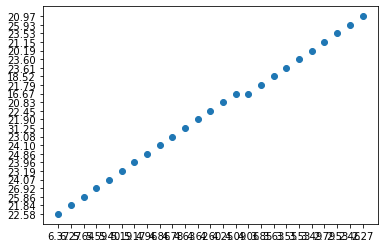

In [431]:
plt.scatter(test['stats_agg'], test['win_rate'])
plt.show()

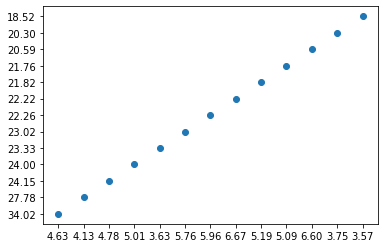

In [409]:
plt.scatter(test['rng_agg'], test['win_rate'])
plt.show()

# Win Rate Analysis

In [136]:
win_rate1 = df[df['win_rate'] < 19]
win_rate2 = df[(df['win_rate'] > 19) & (df['win_rate'] <= 30)]
win_rate3 = df[(df['win_rate'] > 30) & (df['win_rate'] <= 40)]
win_rate4 = df[(df['win_rate'] > 40) & (df['win_rate'] <= 50)]
win_rate5 = df[df['win_rate'] > 50]

In [137]:
total = len(win_rate1) + len(win_rate2) + len(win_rate3) + len(win_rate4) + len(win_rate5)
print("Total pegas for today: {}".format(total))

Total pegas for today: 1140


Less than 19% --- 35.18%   [401]
19% - 30% --- 56.84%   [648]
30% - 40% --- 6.40%   [73]
40% - 50% --- 1.23%   [14]
More than 50% --- 0.35%   [4]


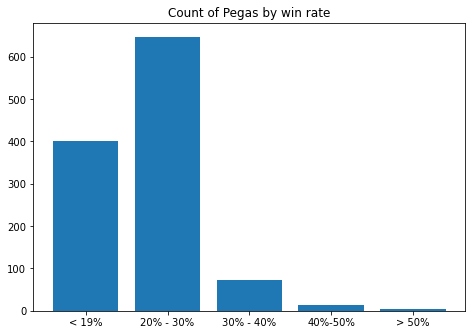

In [138]:
print("Less than 19% --- {:.2f}%   [{}]".format(((len(win_rate1) / total)*100), len(win_rate1)))
print("19% - 30% --- {:.2f}%   [{}]".format(((len(win_rate2) / total)*100), len(win_rate2)))
print("30% - 40% --- {:.2f}%   [{}]".format(((len(win_rate3) / total)*100), len(win_rate3)))
print("40% - 50% --- {:.2f}%   [{}]".format(((len(win_rate4) / total)*100), len(win_rate4)))
print("More than 50% --- {:.2f}%   [{}]".format(((len(win_rate5) / total)*100), len(win_rate5)))

buckets = ['< 19%','20% - 30%','30% - 40%','40%-50%','> 50%']
bucket_counts = [len(win_rate1), len(win_rate2), len(win_rate3), len(win_rate4), len(win_rate5)]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Count of Pegas by win rate')


ax.bar(buckets, bucket_counts)
plt.show()

# Price analysis for different segments 

### Less than 19% win rate

In [140]:
wr = win_rate1.sort_values(by=['price'])
# wr['price'].plot()

# print("Minimum price: {}".format(wr['price'].min()))
# print("Maximum price: {}".format(wr['price'].max()))
# print("Mean price: {:.2f}".format(wr['price'].mean()))
# print("Median price: {}".format(wr['price'].median()))

TypeError: no numeric data to plot

### Win rate between 20% to 30%

In [31]:
wr = win_rate2.sort_values(by=['price'])
# wr['price'].plot()

print("Minimum price: {}".format(wr['price'].min()))
print("Maximum price: {}".format(wr['price'].max()))
print("Mean price: {:.2f}".format(wr['price'].mean()))
print("Median price: {}".format(wr['price'].median()))

Minimum price: 933.0
Maximum price: 610000.0
Mean price: 3375.27
Median price: 1250.0


### Win rate between 30% to 40% 

In [18]:
wr = win_rate3.sort_values(by=['price'])
# wr['price'].plot()

print("Minimum price: {}".format(wr['price'].min()))
print("Maximum price: {}".format(wr['price'].max()))
print("Mean price: {:.2f}".format(wr['price'].mean()))
print("Median price: {}".format(wr['price'].median()))

Minimum price: 1530.0
Maximum price: 100000.0
Mean price: 5322.99
Median price: 1899.0


### Win rate between 40% to 50%

In [19]:
wr = win_rate4.sort_values(by=['price'])
# wr['price'].plot()

print("Minimum price: {}".format(wr['price'].min()))
print("Maximum price: {}".format(wr['price'].max()))
print("Mean price: {:.2f}".format(wr['price'].mean()))
print("Median price: {}".format(wr['price'].median()))

Minimum price: 1999.0
Maximum price: 100000.0
Mean price: 13479.35
Median price: 2997.0


### Win rate greater than 50%

In [20]:
wr = win_rate5.sort_values(by=['price'])
# wr['price'].plot()

print("Minimum price: {}".format(wr['price'].min()))
print("Maximum price: {}".format(wr['price'].max()))
print("Mean price: {:.2f}".format(wr['price'].mean()))
print("Median price: {}".format(wr['price'].median()))

Minimum price: 24000.0
Maximum price: 649000.0
Mean price: 257333.33
Median price: 99000.0


In [32]:
# win_rate2[win_rate2['price'] == 610000]

In [35]:
test = df[df['price'] <= 3000]
test = test.sort_values(by=['win_rate'], ascending=False).head(20) 
# test = test.sort_values(by=['win_rate'], ascending=False)
print(test.head())


    status                                            listing  \
567   True  {'id': 176702, 'nft': '0xD50D167DD35D256e19E2F...   
358   True  {'id': 177890, 'nft': '0xD50D167DD35D256e19E2F...   
172   True  {'id': 178472, 'nft': '0xD50D167DD35D256e19E2F...   
581   True  {'id': 176592, 'nft': '0xD50D167DD35D256e19E2F...   
476   True  {'id': 177207, 'nft': '0xD50D167DD35D256e19E2F...   

                                                   nft   price  \
567  {'id': 174199, 'name': 'Sw33t Potato', 'ownerI...  2900.0   
358  {'id': 127459, 'name': 'Twiggy Whisperer', 'ow...  3000.0   
172  {'id': 170049, 'name': 'I Love You', 'ownerId'...  2800.0   
581  {'id': 153499, 'name': 'Baba Yaga | 168', 'own...  2250.0   
476  {'id': 134159, 'name': 'fpsbbsksvcgmrxsbsyiunc...  2888.0   

     all_stats_mean  rng_mean   win_rate message  
567        6.461667    6.7625  46.428571     NaN  
358        4.040000    5.3300  44.262295     NaN  
172        4.326667    5.9525  44.230769     NaN  
581     

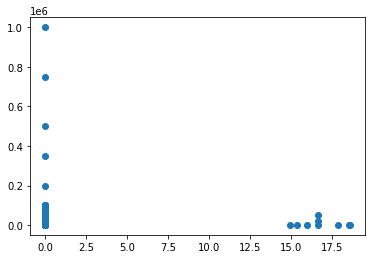

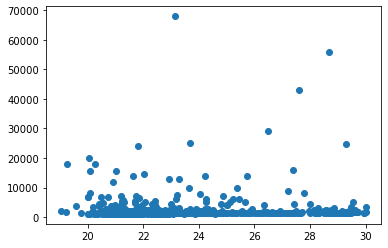

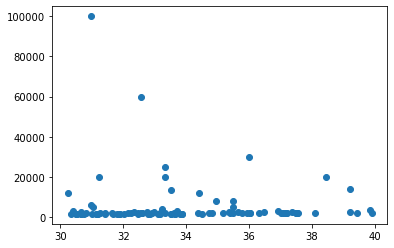

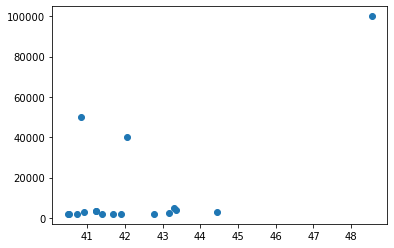

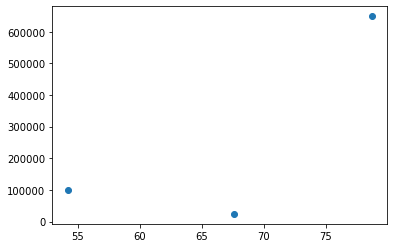

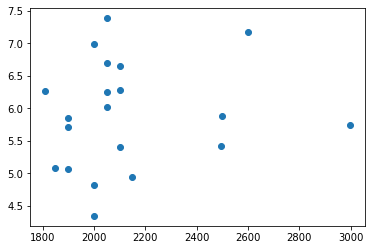

In [15]:
plt.scatter(win_rate1['win_rate'], win_rate1['price'])
plt.show()

plt.scatter(win_rate2['win_rate'], win_rate2['price'])
plt.show()

plt.scatter(win_rate3['win_rate'], win_rate3['price'])
plt.show()

plt.scatter(win_rate4['win_rate'], win_rate4['price'])
plt.show()

plt.scatter(win_rate5['win_rate'], win_rate5['price'])
plt.show()


# plt.scatter(test['stats_mean'], test['win_rate'])
# plt.show()


# plt.scatter(test['price'], test['all_stats_mean'])
# plt.show()

plt.scatter(test['price'], test['rng_mean'])
plt.show()